### Libraries Importing

In [1]:
from pymongo import MongoClient
import os
from dotenv import load_dotenv
from urllib.parse import urlparse, quote_plus
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

### feature loading

In [2]:

load_dotenv()
mongo_uri = os.getenv("MONGO_URI")

parsed = urlparse(mongo_uri)
if parsed.username:
    escaped_user = quote_plus(parsed.username)
    escaped_pass = quote_plus(parsed.password) if parsed.password else ''
    netloc = f"{escaped_user}:{escaped_pass}@{parsed.hostname}"
    if parsed.port:
        netloc += f":{parsed.port}"
    mongo_uri = parsed._replace(netloc=netloc).geturl()

client = MongoClient(mongo_uri)

db = client["aqi_feature_store"]
collection = db["hourly_features"]

data = list(collection.find({}, {"_id": 0}))
df = pd.DataFrame(data)



In [3]:
df.shape

(5168, 15)

In [4]:
df.tail()

,timestamp,seasons,hour,month,year,day_of_week,timeof_day,aqi_lag_1,aqi_lag_2,aqi_lag_3,aqi_lag_6,aqi_lag_12,aqi_lag_24,aqi_24hr_avg,aqi
5163,1772138667,3,20,2,2026,3,2,5.0,5.0,5.0,4.0,4.0,4.0,4.21,5
5164,1772141846,3,21,2,2026,3,3,5.0,5.0,5.0,4.0,4.0,4.0,4.25,5
5165,1772145583,3,22,2,2026,3,3,5.0,5.0,5.0,5.0,4.0,4.0,4.29,5
5166,1772148986,3,23,2,2026,3,3,5.0,5.0,5.0,5.0,4.0,4.0,4.29,4
5167,1772159549,3,2,2,2026,4,3,4.0,5.0,5.0,5.0,4.0,4.0,4.33,5


In [5]:
df.columns

Index(['timestamp', 'seasons', 'hour', 'month', 'year', 'day_of_week',
       'timeof_day', 'aqi_lag_1', 'aqi_lag_2', 'aqi_lag_3', 'aqi_lag_6',
       'aqi_lag_12', 'aqi_lag_24', 'aqi_24hr_avg', 'aqi'],
      dtype='object')

###  Create 72-step target (direct multi-output)

In [6]:
HORIZON = 72

y = pd.concat(
    [df["aqi"].shift(-i) for i in range(1, HORIZON + 1)],
    axis=1
)
y.columns = [f"aqi_t+{i}" for i in range(1, HORIZON + 1)]

X = df.drop(columns=["aqi", "timestamp"])

X = X.iloc[:-HORIZON]
y = y.iloc[:-HORIZON]


### time based train test split

In [7]:
split = int(len(X) * 0.8)

X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]


In [8]:
from sklearn.multioutput import MultiOutputRegressor

### Train XGBoost direct multi-output model

In [9]:
from xgboost import XGBRegressor
from sklearn.multioutput import MultiOutputRegressor

xgboost_model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
)

xgboost_model.fit(X_train, y_train)


,estimator,"XGBRegressor(...state=42, ...)"
,n_jobs,None
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,early_stopping_rounds,None
,enable_categorical,False


### Predicting AQI

In [10]:
y_pred_72 = xgboost_model.predict(X_test.iloc[[-1]])


In [11]:
y_pred= xgboost_model.predict(X_test)


### Convert to 3-day AQI for UI

In [12]:
import numpy as np

day1 = np.mean(y_pred_72[0][:24])
day2 = np.mean(y_pred_72[0][24:48])
day3 = np.mean(y_pred_72[0][48:72])

print(day1, day2, day3)


4.8427415 5.0720997 4.967339


### Performance Evaluation

In [13]:
# Overall metrics (all 72 hours)
xgb_mae = mean_absolute_error(y_test, y_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
xgb_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Overall MAE  : {xgb_mae:.3f}")
print(f"Overall RMSE : {xgb_rmse:.3f}")
print(f"Overall MAPE : {xgb_mape:.2f}%")

Overall MAE  : 0.497
Overall RMSE : 0.676
Overall MAPE : 11.31%


# Shap Ananlysis

SHAP Analysis for XGBoost (First Hour Prediction)


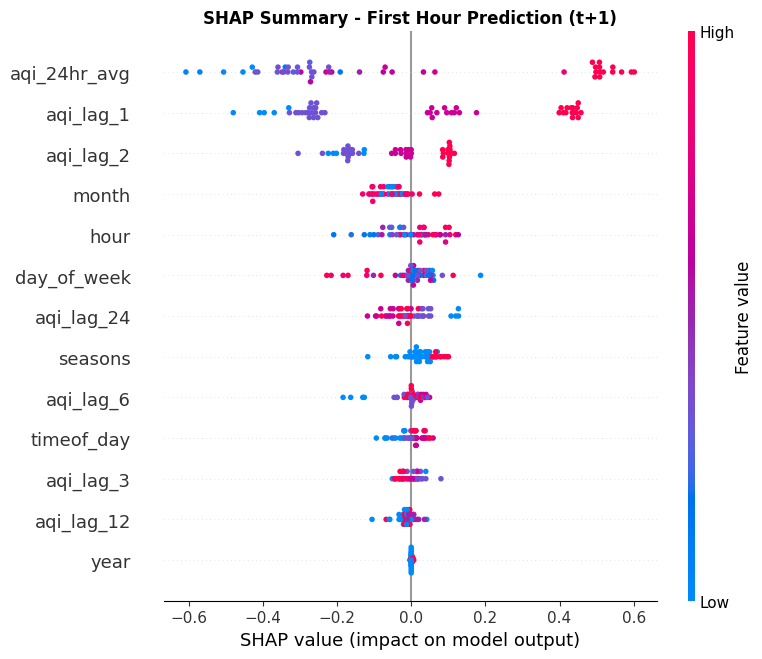

In [21]:
import shap
import matplotlib.pyplot as plt

print("SHAP Analysis for XGBoost (First Hour Prediction)")

# Get the model for first hour (t+1)
first_hour_model = xgboost_model.estimators_[0]

# Take a sample of test data
X_sample = X_test.iloc[:50]

# Create explainer
explainer = shap.TreeExplainer(first_hour_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_sample)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values, 
    X_sample, 
    feature_names=X_test.columns.tolist(),
    show=False
)
plt.title('SHAP Summary - First Hour Prediction (t+1)', fontweight='bold')
plt.tight_layout()
plt.savefig('shap_summary_xgb.png', dpi=300, bbox_inches='tight')
plt.show()


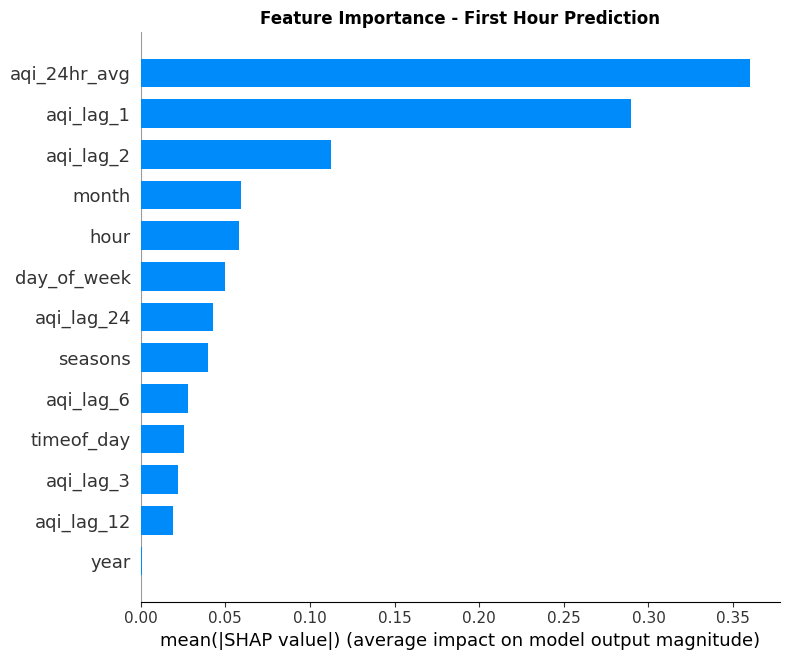

In [22]:
# Feature importance bar plot
plt.figure(figsize=(10, 8))
shap.summary_plot(
    shap_values, 
    X_sample, 
    feature_names=X_test.columns.tolist(),
    plot_type="bar",
    show=False
)
plt.title('Feature Importance - First Hour Prediction', fontweight='bold')
plt.tight_layout()
plt.savefig('shap_importance_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

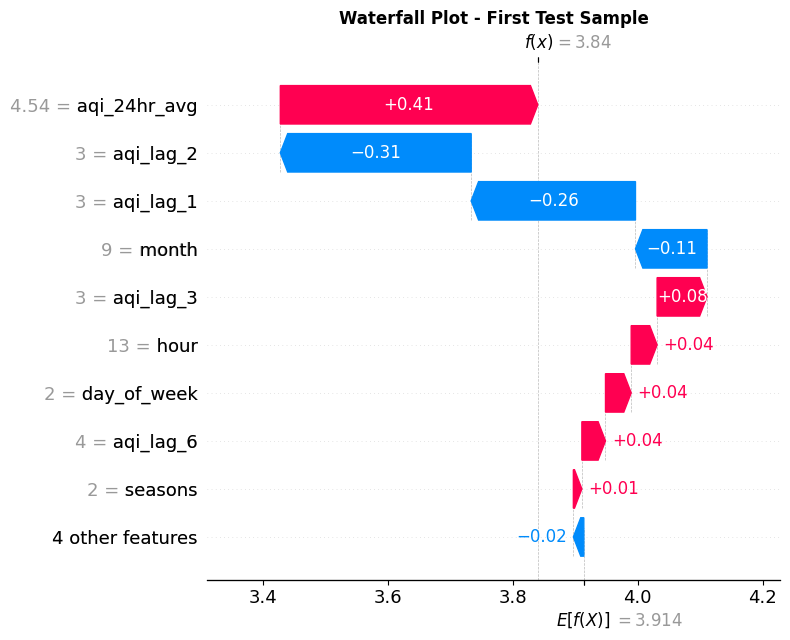

Simple SHAP Analysis Complete!


In [ ]:
# Waterfall plot for a single prediction
plt.figure(figsize=(12, 6))
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[0],
        base_values=explainer.expected_value,
        data=X_sample.iloc[0].values,
        feature_names=X_test.columns.tolist()
    ),
    show=False
)
plt.title('Waterfall Plot - First Test Sample', fontweight='bold')
plt.tight_layout()
plt.savefig('shap_waterfall_xgb.png', dpi=300, bbox_inches='tight')
plt.show()


### Ransom Forest Regressor Training

In [15]:
from sklearn.ensemble import RandomForestRegressor
rf_model = MultiOutputRegressor(RandomForestRegressor(
    n_estimators=50,
    max_depth=10,
    n_jobs=-1,
    random_state=42
)
)
rf_model.fit(X_train, y_train)


,estimator,RandomForestR...ndom_state=42)
,n_jobs,None
,n_estimators,50
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0


### Prediction

In [16]:
y_pred = rf_model.predict(X_test) 

In [17]:
y_pred_72 = rf_model.predict(X_test.iloc[[-1]])

In [18]:
import numpy as np

day1 = np.mean(y_pred_72[0][:24])
day2 = np.mean(y_pred_72[0][24:48])
day3 = np.mean(y_pred_72[0][48:72])

print(day1, day2, day3)


4.668965861340955 4.799415926289462 4.691493105030659


### Performace Evaluation

In [19]:

rf_mae = mean_absolute_error(y_test, y_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
rf_mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"Overall MAE  : {rf_mae:.3f}")
print(f"Overall RMSE : {rf_rmse:.3f}")
print(f"Overall MAPE : {rf_mape:.2f}%")

Overall MAE  : 0.504
Overall RMSE : 0.697
Overall MAPE : 11.44%


# Shap Analysis for Random Forest

SHAP Analysis for Random Forest Model


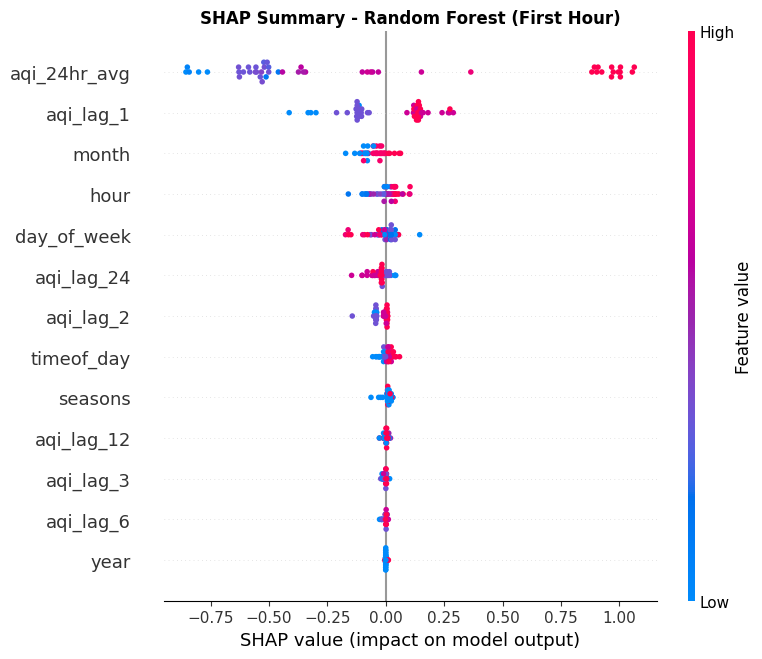

In [24]:
print("SHAP Analysis for Random Forest Model")

# Get model for first hour
rf_first_hour = rf_model.estimators_[0]

# Take sample
X_sample = X_test.iloc[:50]

# Create explainer
explainer_rf = shap.TreeExplainer(rf_first_hour)

# Calculate SHAP values
shap_values_rf = explainer_rf.shap_values(X_sample)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(
    shap_values_rf, 
    X_sample, 
    feature_names=X_test.columns.tolist(),
    show=False
)
plt.title('SHAP Summary - Random Forest (First Hour)', fontweight='bold')
plt.tight_layout()
plt.savefig('shap_rf_summary.png', dpi=300, bbox_inches='tight')
plt.show()

## MLP Model 

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


In [18]:
import torch
import torch.nn as nn

class AQIMLP(nn.Module):
    def __init__(self, input_dim, output_dim=72):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        return self.net(x)


In [ ]:
mlp_model = AQIMLP(input_dim=X_train_scaled.shape[1])

Xtr = torch.tensor(X_train_scaled, dtype=torch.float32)
ytr = torch.tensor(y_train.values, dtype=torch.float32)

optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(50):
    optimizer.zero_grad()
    output = mlp_model(Xtr)
    loss = criterion(output , ytr)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 15.7308
Epoch 10, Loss: 14.2252
Epoch 20, Loss: 10.4530
Epoch 30, Loss: 4.5717
Epoch 40, Loss: 1.9361


1. Prediction on test set

In [20]:
mlp_model.eval()
with torch.no_grad():
    Xte = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_pred_72 = mlp_model(Xte).numpy()


2. Convert 72-hour prediction → 3-day AQI (daily average)

In [21]:
import numpy as np

# average each 24-hour block
day1_avg = y_pred_72[:, 0:24].mean(axis=1)
day2_avg = y_pred_72[:, 24:48].mean(axis=1)
day3_avg = y_pred_72[:, 48:72].mean(axis=1)

daily_aqi_pred = np.vstack([day1_avg, day2_avg, day3_avg]).T


In [22]:
daily_aqi_pred_rounded = np.clip(
    np.round(daily_aqi_pred), 2, 5
)


In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_true = y_test.values

mlp_mae = mean_absolute_error(y_true, y_pred_72)
mlp_rmse = np.sqrt(mean_squared_error(y_true, y_pred_72))
mlp_mape = np.mean(np.abs((y_true - y_pred_72) / y_true)) * 100

print(f"Overall MAE  : {mlp_mae:.3f}")
print(f"Overall RMSE : {mlp_rmse:.3f}")
print(f"Overall MAPE : {mlp_mape:.2f}%")


Overall MAE  : 1.807
Overall RMSE : 1.906
Overall MAPE : 37.36%


In [24]:
import dagshub
import mlflow

dagshub.init(
    repo_owner="najmarazzaq761",
    repo_name="aqi_prediction_models",
    mlflow=True
)

c:\Users\Asad\Desktop\AQI_predictor\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Accessing as najmarazzaq761

Initialized MLflow to track repo "najmarazzaq761/aqi_prediction_models"

Repository najmarazzaq761/aqi_prediction_models initialized!

In [25]:
import mlflow

with mlflow.start_run(run_name="XGBoost_72hr"):
    mlflow.log_param("model", "XGBoost")
    mlflow.log_param("horizon", 72)

    mlflow.log_metric("MAE", xgb_mae)
    mlflow.log_metric("RMSE", xgb_rmse)
    mlflow.log_metric("MAPE", xgb_mape)

    mlflow.sklearn.log_model(
        xgboost_model,
        artifact_path="model",
        registered_model_name="AQI_Forecaster"
    )


2026/02/05 15:47:47 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
c:\Users\Asad\Desktop\AQI_predictor\.venv\lib\site-packages\mlflow\models\model.py:1209: FutureWarning: Saving scikit-learn models in the pickle or cloudpickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is the 'skops' format.
  flavor.save_model(path=local_path, mlflow_model=mlflow_model, **kwargs)
Registered model 'AQI_Forecaster' already exists. Creating a new version of this model...
2026/02/05 15:50:28 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: AQI_Forecaster, version 4
Created version '4' of model 'AQI_Forecaster'.


🏃 View run XGBoost_72hr at: https://dagshub.com/najmarazzaq761/aqi_prediction_models.mlflow/#/experiments/0/runs/b7d8be59fa14406794c02de9db5aba27
🧪 View experiment at: https://dagshub.com/najmarazzaq761/aqi_prediction_models.mlflow/#/experiments/0


In [26]:
with mlflow.start_run(run_name="MLP_72hr"):
    mlflow.log_param("model", "MLP")
    mlflow.log_param("horizon", 72)

    mlflow.log_metric("MAE", mlp_mae)
    mlflow.log_metric("RMSE", mlp_rmse)
    mlflow.log_metric("MAPE", mlp_mape)

    mlflow.pytorch.log_model(
        mlp_model,
        artifact_path ="model",
        registered_model_name="AQI_Forecaster"
    )


2026/02/05 15:50:50 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2026/02/05 15:50:53 WARNING mlflow.pytorch: Saving pytorch model by Pickle or CloudPickle format requires exercising caution because these formats rely on Python's object serialization mechanism, which can execute arbitrary code during deserialization.The recommended safe alternative is to set 'export_model' to True to save the pytorch model using the safe graph model format.
Registered model 'AQI_Forecaster' already exists. Creating a new version of this model...
2026/02/05 15:51:06 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: AQI_Forecaster, version 5
Created version '5' of model 'AQI_Forecaster'.


🏃 View run MLP_72hr at: https://dagshub.com/najmarazzaq761/aqi_prediction_models.mlflow/#/experiments/0/runs/be35f3edd43f4986942efc77574151dd
🧪 View experiment at: https://dagshub.com/najmarazzaq761/aqi_prediction_models.mlflow/#/experiments/0


In [27]:
import mlflow

with mlflow.start_run(run_name="rf_72hr"):
    mlflow.log_param("model", "RandomForest")
    mlflow.log_param("horizon", 72)

    mlflow.log_metric("MAE", rf_mae)
    mlflow.log_metric("RMSE", rf_rmse)
    mlflow.log_metric("MAPE", rf_mape)

    mlflow.sklearn.log_model(
        rf_model,
        artifact_path="model",
        registered_model_name="AQI_Forecaster"
    )


2026/02/05 15:51:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
Registered model 'AQI_Forecaster' already exists. Creating a new version of this model...
2026/02/05 15:55:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: AQI_Forecaster, version 6
Created version '6' of model 'AQI_Forecaster'.


🏃 View run rf_72hr at: https://dagshub.com/najmarazzaq761/aqi_prediction_models.mlflow/#/experiments/0/runs/f4fefa418f3a4030b10e3fd942a2cbcd
🧪 View experiment at: https://dagshub.com/najmarazzaq761/aqi_prediction_models.mlflow/#/experiments/0
